# Oscillation Models Evaluator

Compare multiple RheoJAX oscillation models on polystyrene mastercurve data.

**Data:** examples/data/mastercurves/master_curve_ps_oscillation_data.csv

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


## Load oscillation dataset (polystyrene mastercurve)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'mastercurves'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Evaluate multiple models

In [4]:
models = {
    'GM-4': GeneralizedMaxwell(n_modes=4, modulus_type='tensile'),
    'GM-6': GeneralizedMaxwell(n_modes=6, modulus_type='tensile'),
    'FracMax': FractionalMaxwellModel(),
}
results = []
for name, model in models.items():
    try:
        model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
        pred = model.predict(omega)
        if pred.ndim == 2:
            pred = pred[:,0] + 1j*pred[:,1]
        r2 = r2_complex(G_star, pred)
        results.append({'model': name, 'r2': r2})
    except Exception as exc:
        results.append({'model': name, 'r2': np.nan, 'error': str(exc)})

pd.DataFrame(results)


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.689933s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.0574e+11 | elapsed=2.690s | final_gradient_norm=6.7697e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.701667s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.0574e+11 | elapsed=0.702s | final_gradient_norm=6.7697e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.129187s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=73 | final_cost=3.5477e+11 | elapsed=1.129s | final_gradient_norm=3.0624e+18


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.648920s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=1.649s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.591212s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=0.591s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.720995s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=36 | final_cost=3.9375e+10 | elapsed=1.721s | final_gradient_norm=1.7507e+17


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.853868s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.0994 | elapsed=1.854s | final_gradient_norm=0.0065


,model,r2
0,GM-4,9.981214e-01
1,GM-6,9.996658e-01
2,FracMax,-2.375968e+83


## Plot best-fit overlay

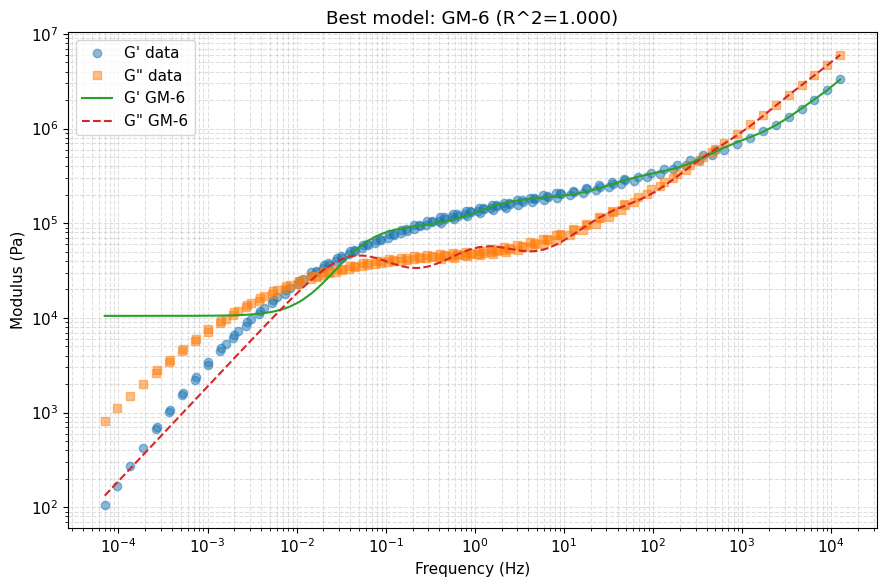

In [5]:
best_candidates = [r for r in results if np.isfinite(r.get('r2', np.nan))]
if not best_candidates:
    print('No successful models')
else:
    best = max(best_candidates, key=lambda x: x['r2'])
    best_model = models[best['model']]
    best_pred = best_model.predict(omega)
    if hasattr(best_pred, 'ndim') and best_pred.ndim == 2:
        best_pred = best_pred[:,0] + 1j*best_pred[:,1]
    freq_hz = omega/(2*np.pi)

    fig, ax = plt.subplots(figsize=(9,6))
    ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
    ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
    ax.loglog(freq_hz, np.real(best_pred), '-', label=f"G' {best['model']}")
    ax.loglog(freq_hz, np.imag(best_pred), '--', label=f'G" {best["model"]}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Modulus (Pa)')
    ax.set_title(f"Best model: {best['model']} (R^2={best['r2']:.3f})")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.552302s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.0994 | elapsed=0.552s | final_gradient_norm=0.0065


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.897299s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=0.897s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.792613s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=0.793s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.645165s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=36 | final_cost=3.9375e+10 | elapsed=0.645s | final_gradient_norm=1.7507e+17


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


Skipping best_model due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'
Dataset 0 ranking: [('model', 0.285)]


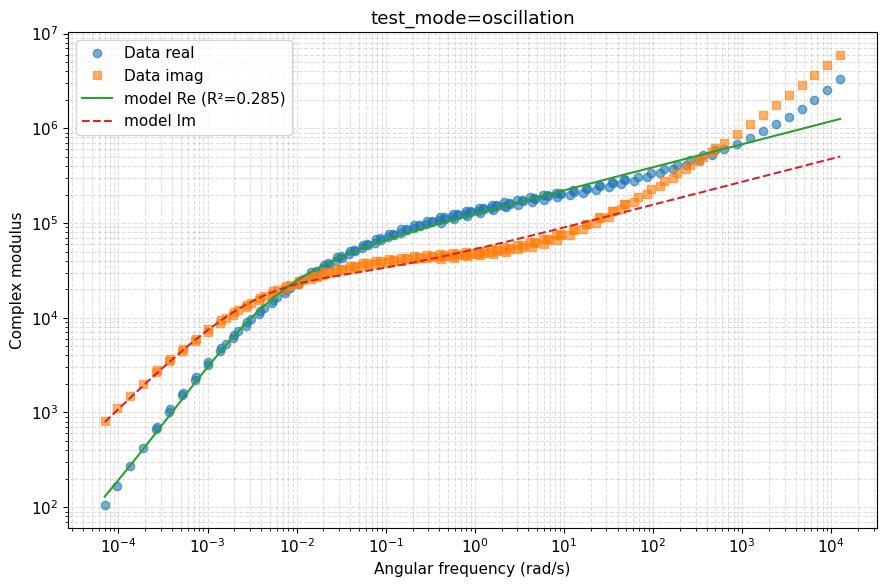

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<03:35,  3.25it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   5%|▌         | 37/700 [00:00<00:05, 115.88it/s, 63 steps of size 9.31e-04. acc. prob=0.89]

warmup:   8%|▊         | 59/700 [00:00<00:07, 84.38it/s, 511 steps of size 7.45e-04. acc. prob=0.92]

warmup:  11%|█         | 74/700 [00:00<00:07, 78.89it/s, 1023 steps of size 6.44e-04. acc. prob=0.93]

warmup:  12%|█▏        | 86/700 [00:01<00:08, 74.53it/s, 255 steps of size 6.12e-04. acc. prob=0.93] 

warmup:  14%|█▎        | 96/700 [00:01<00:08, 74.74it/s, 1023 steps of size 4.43e-04. acc. prob=0.93]

warmup:  15%|█▌        | 105/700 [00:01<00:08, 73.34it/s, 1023 steps of size 5.79e-03. acc. prob=0.94]

warmup:  16%|█▋        | 114/700 [00:01<00:07, 73.68it/s, 255 steps of size 4.98e-03. acc. prob=0.94] 

warmup:  18%|█▊        | 123/700 [00:01<00:07, 74.04it/s, 1023 steps of size 3.43e-03. acc. prob=0.94]

warmup:  19%|█▉        | 132/700 [00:01<00:07, 75.83it/s, 1023 steps of size 4.11e-03. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:01<00:07, 71.06it/s, 1023 steps of size 4.14e-03. acc. prob=0.95]

warmup:  21%|██        | 148/700 [00:02<00:07, 71.61it/s, 255 steps of size 3.85e-03. acc. prob=0.95] 

warmup:  22%|██▏       | 156/700 [00:02<00:07, 68.90it/s, 1023 steps of size 1.73e-03. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [00:02<00:08, 65.38it/s, 1023 steps of size 1.77e-03. acc. prob=0.95]

warmup:  24%|██▍       | 171/700 [00:02<00:08, 63.74it/s, 423 steps of size 1.52e-03. acc. prob=0.95] 

warmup:  25%|██▌       | 178/700 [00:02<00:08, 60.80it/s, 767 steps of size 1.99e-03. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [00:02<00:08, 61.09it/s, 1023 steps of size 2.33e-03. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [00:02<00:08, 61.18it/s, 1023 steps of size 1.95e-03. acc. prob=0.95]

warmup:  28%|██▊       | 199/700 [00:02<00:08, 61.10it/s, 695 steps of size 1.92e-03. acc. prob=0.96] 

sample:  30%|██▉       | 207/700 [00:02<00:07, 64.48it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  31%|███       | 216/700 [00:03<00:06, 69.54it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  32%|███▏      | 223/700 [00:03<00:07, 63.16it/s, 39 steps of size 1.94e-03. acc. prob=0.98]  

sample:  33%|███▎      | 230/700 [00:03<00:07, 61.89it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  34%|███▍      | 237/700 [00:03<00:07, 62.72it/s, 143 steps of size 1.94e-03. acc. prob=0.98] 

sample:  35%|███▍      | 244/700 [00:03<00:07, 62.42it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  36%|███▌      | 251/700 [00:03<00:06, 64.15it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  37%|███▋      | 258/700 [00:03<00:06, 63.59it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  38%|███▊      | 265/700 [00:03<00:06, 62.76it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  39%|███▉      | 272/700 [00:03<00:06, 63.98it/s, 767 steps of size 1.94e-03. acc. prob=0.98] 

sample:  40%|███▉      | 279/700 [00:04<00:06, 60.79it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  41%|████      | 286/700 [00:04<00:06, 59.43it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  42%|████▏     | 292/700 [00:04<00:07, 57.16it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [00:04<00:06, 57.63it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  44%|████▍     | 307/700 [00:04<00:06, 63.56it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  45%|████▍     | 314/700 [00:04<00:06, 63.43it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  46%|████▌     | 321/700 [00:04<00:06, 62.02it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  47%|████▋     | 328/700 [00:04<00:06, 61.63it/s, 839 steps of size 1.94e-03. acc. prob=0.98] 

sample:  48%|████▊     | 335/700 [00:05<00:06, 59.43it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  49%|████▊     | 341/700 [00:05<00:06, 57.50it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  50%|████▉     | 347/700 [00:05<00:06, 58.14it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  50%|█████     | 353/700 [00:05<00:06, 57.38it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  51%|█████▏    | 359/700 [00:05<00:06, 53.78it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  52%|█████▏    | 365/700 [00:05<00:06, 52.08it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  53%|█████▎    | 371/700 [00:05<00:07, 45.94it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  54%|█████▍    | 377/700 [00:05<00:06, 47.70it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  55%|█████▌    | 385/700 [00:06<00:05, 54.00it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  56%|█████▌    | 392/700 [00:06<00:05, 57.62it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  57%|█████▋    | 398/700 [00:06<00:05, 57.41it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  58%|█████▊    | 404/700 [00:06<00:05, 57.93it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  59%|█████▊    | 410/700 [00:06<00:04, 58.20it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  59%|█████▉    | 416/700 [00:06<00:04, 58.42it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  60%|██████    | 422/700 [00:06<00:04, 57.13it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  61%|██████    | 428/700 [00:06<00:04, 56.76it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  62%|██████▏   | 434/700 [00:06<00:04, 56.59it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  63%|██████▎   | 440/700 [00:06<00:04, 56.64it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  64%|██████▎   | 446/700 [00:07<00:04, 55.96it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  65%|██████▍   | 452/700 [00:07<00:05, 46.77it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  66%|██████▌   | 459/700 [00:07<00:04, 50.93it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  67%|██████▋   | 466/700 [00:07<00:04, 54.61it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  68%|██████▊   | 473/700 [00:07<00:04, 56.47it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  69%|██████▊   | 480/700 [00:07<00:03, 59.86it/s, 255 steps of size 1.94e-03. acc. prob=0.98] 

sample:  70%|██████▉   | 487/700 [00:07<00:03, 61.72it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  71%|███████   | 494/700 [00:07<00:03, 58.41it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  72%|███████▏  | 501/700 [00:08<00:03, 59.42it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  73%|███████▎  | 508/700 [00:08<00:03, 58.21it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  73%|███████▎  | 514/700 [00:08<00:03, 57.46it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  74%|███████▍  | 520/700 [00:08<00:03, 52.58it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  75%|███████▌  | 526/700 [00:08<00:03, 50.32it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  76%|███████▌  | 532/700 [00:08<00:03, 50.44it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  77%|███████▋  | 538/700 [00:08<00:03, 50.90it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  78%|███████▊  | 545/700 [00:08<00:02, 55.24it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  79%|███████▉  | 552/700 [00:09<00:02, 58.27it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  80%|███████▉  | 559/700 [00:09<00:02, 60.02it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  81%|████████  | 566/700 [00:09<00:02, 59.64it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  82%|████████▏ | 573/700 [00:09<00:02, 59.41it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  83%|████████▎ | 579/700 [00:09<00:02, 58.68it/s, 903 steps of size 1.94e-03. acc. prob=0.98] 

sample:  84%|████████▎ | 585/700 [00:09<00:01, 58.14it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  85%|████████▍ | 593/700 [00:09<00:01, 63.42it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  86%|████████▌ | 600/700 [00:09<00:01, 60.26it/s, 671 steps of size 1.94e-03. acc. prob=0.98] 

sample:  87%|████████▋ | 607/700 [00:09<00:01, 57.39it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  88%|████████▊ | 613/700 [00:10<00:01, 54.53it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  89%|████████▊ | 620/700 [00:10<00:01, 57.84it/s, 375 steps of size 1.94e-03. acc. prob=0.98] 

sample:  90%|████████▉ | 627/700 [00:10<00:01, 60.75it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  91%|█████████ | 634/700 [00:10<00:01, 58.68it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  92%|█████████▏| 641/700 [00:10<00:01, 58.89it/s, 895 steps of size 1.94e-03. acc. prob=0.98] 

sample:  92%|█████████▏| 647/700 [00:10<00:00, 56.08it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  93%|█████████▎| 653/700 [00:10<00:00, 56.23it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  94%|█████████▍| 659/700 [00:10<00:00, 56.24it/s, 767 steps of size 1.94e-03. acc. prob=0.98] 

sample:  95%|█████████▌| 665/700 [00:10<00:00, 54.27it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  96%|█████████▌| 671/700 [00:11<00:00, 55.61it/s, 655 steps of size 1.94e-03. acc. prob=0.99] 

sample:  97%|█████████▋| 678/700 [00:11<00:00, 58.03it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [00:11<00:00, 58.76it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [00:11<00:00, 54.41it/s, 687 steps of size 1.94e-03. acc. prob=0.99] 

sample: 100%|█████████▉| 697/700 [00:11<00:00, 54.06it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:11<00:00, 60.42it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

Dataset 0: Bayesian inference complete for model


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'tau\n0'}>]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)